# Inspect ImageNet2012 torchvision Dataset

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import tv_tensors
from torchvision import transforms
from torchvision.transforms import v2  # TODO Verify: not used, v2 is somehow slower in this case

## Inspect Content

Ref for data preparation: https://github.com/pytorch/examples/blob/main/imagenet/extract_ILSVRC.sh

In [2]:
dataset_train = torchvision.datasets.ImageNet(root='../data/imagenet2012/', split='train',
                                              transform=torchvision.transforms.ToTensor())
dataset_val = torchvision.datasets.ImageNet(root='../data/imagenet2012/', split='val',
                                            transform=torchvision.transforms.ToTensor())

In [3]:
print(f"Len of train dataset: {len(dataset_train):,}")
print(f"Len of val dataset: {len(dataset_val):,}")
print(f"Number of classes: {len(dataset_train.classes)}")
print(f"\nFirst 10th classes")
for i in range(10):
    print(f"Class {i}: {dataset_train.classes[i]}, ID={dataset_train.class_to_idx[dataset_train.classes[i][0]]}")
print(f"\nSample")
x, y = dataset_train[2]
print(f"Image: {x} ({type(x)=}), hw={x.size()}")
print(f"Label: {y} ({type(y)=})")

Len of train dataset: 1,281,167
Len of val dataset: 50,000
Number of classes: 1000

First 10th classes
Class 0: ('tench', 'Tinca tinca'), ID=0
Class 1: ('goldfish', 'Carassius auratus'), ID=1
Class 2: ('great white shark', 'white shark', 'man-eater', 'man-eating shark', 'Carcharodon carcharias'), ID=2
Class 3: ('tiger shark', 'Galeocerdo cuvieri'), ID=3
Class 4: ('hammerhead', 'hammerhead shark'), ID=4
Class 5: ('electric ray', 'crampfish', 'numbfish', 'torpedo'), ID=5
Class 6: ('stingray',), ID=6
Class 7: ('cock',), ID=7
Class 8: ('hen',), ID=8
Class 9: ('ostrich', 'Struthio camelus'), ID=9

Sample
Image: tensor([[[0.1216, 0.1412, 0.1373,  ..., 0.2549, 0.3020, 0.2941],
         [0.1373, 0.1529, 0.1529,  ..., 0.2471, 0.2353, 0.2510],
         [0.1529, 0.1529, 0.1451,  ..., 0.1882, 0.2392, 0.2196],
         ...,
         [0.3137, 0.2706, 0.2549,  ..., 0.4196, 0.3020, 0.1294],
         [0.3176, 0.2902, 0.2667,  ..., 0.4157, 0.2980, 0.1294],
         [0.2902, 0.3137, 0.2941,  ..., 0.4039,

In [4]:
torch.manual_seed(1337)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True)
print(f"Example imgs batch: {next(iter(dataloader_train))[0].size()}")
print(f"Example labels batch: {next(iter(dataloader_train))[1].size()}")

Example imgs batch: torch.Size([1, 3, 375, 500])
Example labels batch: torch.Size([1])


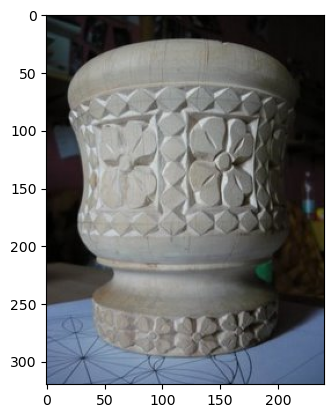

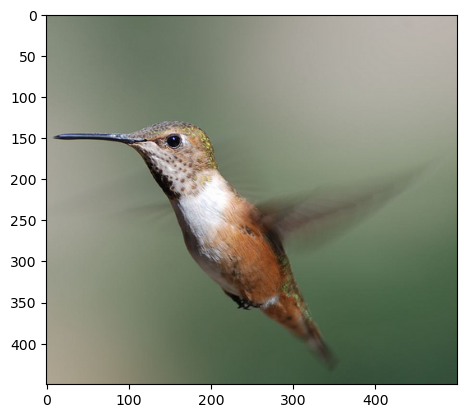

In [5]:
# data get shuffled every time iterator is created

dataiter_train1 = iter(dataloader_train)
img_train1, label_train1 = next(dataiter_train1)
plt.imshow(img_train1[0].permute(1, 2, 0))
plt.show()

dataiter_train2 = iter(dataloader_train)
img_train2, label_train2 = next(dataiter_train2)
plt.imshow(img_train2[0].permute(1, 2, 0))
plt.show()

## Inspect Transforms

In [6]:
dataset_name = 'imagenet2012'

# # No augmentation
# TODO

In [7]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Image, shape={img.size()}")
    plt.show()

### No transform

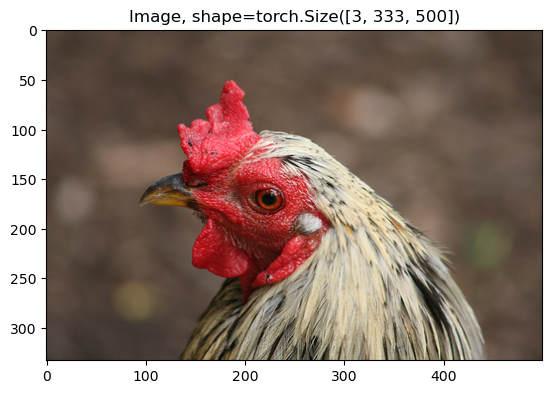

Label: 7


In [8]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

### Validation transform (center crop)

In [26]:
img_h = 256
img_w = 256
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)

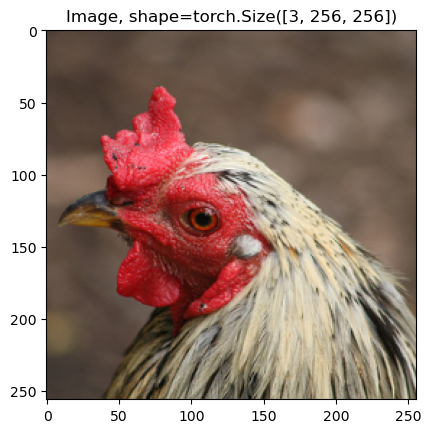

Label: 7


In [27]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train', # split='val'
    transform=v2.Compose([
        v2.ToImage(),
        v2.Resize(size=max(img_h, img_w)),  # OR: v2.Resize(size=max(img_h, img_w) * 232 // 224),  # OR: v2.Resize(size=max(img_h, img_w) * 256 // 224),
        v2.CenterCrop(size=(img_h, img_w)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

### Validation transform (letterbox)

In [28]:
img_h = 256
img_w = 256
letterbox = True
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)
fill = (123.0, 117.0, 104.0)

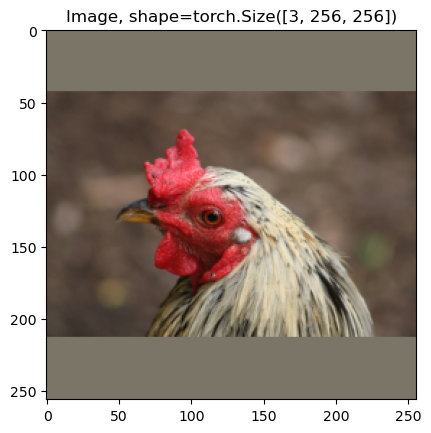

Label: 7


In [29]:
from typing import Any, Callable, cast, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
from torchvision.transforms.v2 import functional as F, InterpolationMode
from torchvision.transforms.v2.functional._utils import _FillType
class Resize(v2.Resize):
    def __init__(
            self,
            letterbox: bool,
            fill:  Union[_FillType, Dict[Union[Type, str], _FillType]] = 0,
            **kwargs,  # params for v2.Resize
        ) -> None:
        super().__init__(**kwargs)
        self.size = self.size + self.size if len(self.size) == 1 else self.size
        self.letterbox = letterbox
        self.fill = fill
        self._fill = v2._utils._setup_fill_arg(fill)
        self.padding_mode = 'constant'  # only support constant padding mode for bounding boxes

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        orig_h, orig_w = v2._utils.query_size(flat_inputs)
        new_h, new_w = self.size
        if not self.letterbox:
            return dict(size=(new_h, new_w))
        else:  # do letterbox
            r_h, r_w = new_h / orig_h, new_w / orig_w
            r = min(r_h, r_w)
            new_unpad_h, new_unpad_w = round(orig_h * r), round(orig_w * r)
            pad_left = pad_right = pad_top = pad_bottom = 0
            if r_w < r_h:
                diff = new_h - new_unpad_h
                pad_top += (diff // 2)
                pad_bottom += (diff - pad_top)
            else:  # r_h <= r_w:
                diff = new_w - new_unpad_w
                pad_left += (diff // 2)
                pad_right += (diff - pad_left)
            padding = [pad_left, pad_top, pad_right, pad_bottom]
            return dict(size=(new_unpad_h, new_unpad_w), padding=padding)

    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        inpt = self._call_kernel(F.resize, inpt, size=params['size'],
                                 interpolation=self.interpolation, antialias=self.antialias)
        if self.letterbox:
            fill = v2._utils._get_fill(self._fill, type(inpt))
            inpt = self._call_kernel(F.pad, inpt, padding=params["padding"], fill=fill, padding_mode=self.padding_mode)
        return inpt


data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train', # split='val'
    transform=v2.Compose([
        v2.ToImage(),
        Resize(size=(img_h, img_w), letterbox=letterbox, fill=fill, antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

### Training transform (simple-aug)

In [30]:
img_h = 256
img_w = 256
brightness = 0.4
contrast = 0.4
saturation = 0.7
hue = 0.015
scale_min = 0.08
scale_max = 1.0
ratio_min = 3.0 / 4.0
ratio_max = 4.0 / 3.0
flip_p = 0.5
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)
fill = (123.0, 117.0, 104.0)

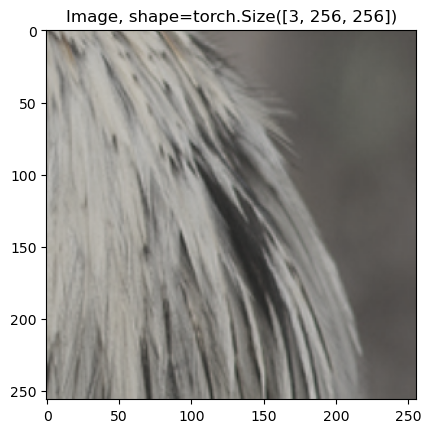

Label: 7


In [31]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        v2.RandomResizedCrop(size=(img_h, img_w), scale=(scale_min, scale_max),
                             ratio=(ratio_min, ratio_max), antialias=True),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

### Training transform (tv-aug)
*From torchvision references/classification/presets.py*

In [32]:
img_h = 256
img_w = 256
scale_min = 0.08
scale_max = 1.0
ratio_min = 3.0 / 4.0
ratio_max = 4.0 / 3.0
flip_p = 0.5
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)
fill = (123.0, 117.0, 104.0)

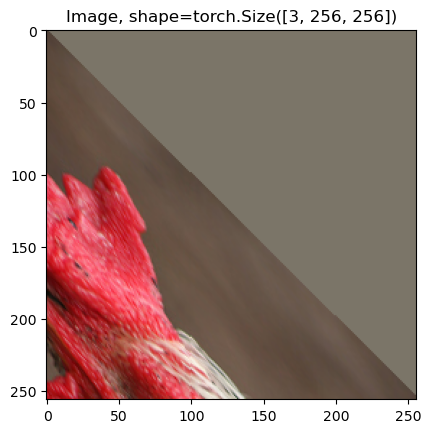

Label: 7


In [33]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=max(img_h, img_w), scale=(scale_min, scale_max),
                             ratio=(ratio_min, ratio_max), antialias=True),
        v2.RandomHorizontalFlip(p=flip_p),
        v2.TrivialAugmentWide(fill=fill),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

### Training transform (voc-aug)

In [41]:
perspective = 0.1
crop_scale = 0.3
ratio_min = 0.5
ratio_max = 2.0
degrees = 0.5
translate = 0.25
scale = 0.5
shear = 0.5
brightness = 0.7
contrast = 0.7
saturation = 0.7
hue = 0.1
flip_p = 0.5
letterbox = True
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)
fill = (123.0, 117.0, 104.0)

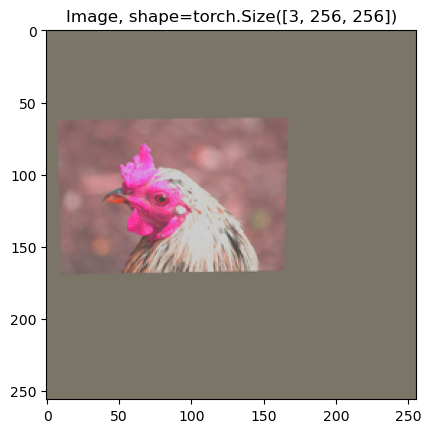

Label: 7


In [171]:
data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train',
    transform=v2.Compose([
        v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        # perspective & affine transform on PIL image solves the issue with black borders
        v2.RandomPerspective(distortion_scale=perspective, fill=fill, interpolation=InterpolationMode.BICUBIC),
        v2.RandomAffine(degrees=degrees, translate=(translate, translate), scale=(1 - scale, 1 + scale),
                        shear=(-shear, shear, -shear, shear), fill=fill, interpolation=InterpolationMode.BICUBIC),
        Resize(size=(img_h, img_w), letterbox=letterbox, fill=fill, antialias=True,
               interpolation=InterpolationMode.BICUBIC),
        v2.ToImage(),  # bicubic interpolation is not supported for tensors
        v2.RandomHorizontalFlip(p=flip_p),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
show_img(dataset_train[9999][0])
print("Label:", dataset_train[9999][1])

## Inspect FakeData

In [35]:
n_data = 10
img_h = 256
img_w = 256
n_class = 1000
dataset_fake = torchvision.datasets.FakeData(size=n_data,
                                             image_size=(3, img_h, img_w),
                                             num_classes=n_class,
                                             transform=v2.Compose([v2.ToImage(),
                                                                   v2.ToDtype(torch.float32, scale=True),]))

example_img.shape=torch.Size([3, 256, 256]), example_label=445
example_img.dtype=torch.float32, example_img.min()=tensor(0.), example_img.max()=tensor(1.)


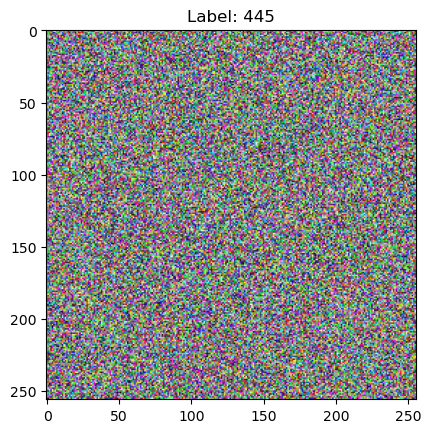

In [36]:
example_img, example_label = dataset_fake[0]
print(f"{example_img.shape=}, {example_label=}")
print(f"{example_img.dtype=}, {example_img.min()=}, {example_img.max()=}")
plt.imshow(example_img.permute(1, 2, 0))
plt.title(f"Label: {example_label}")
plt.show()

In [37]:
dataloader_fake = torch.utils.data.DataLoader(dataset_fake, batch_size=2, shuffle=True)
example_imgs, example_labels = next(iter(dataloader_fake))
print(f"{example_imgs.shape=}, {example_labels.shape=}")

example_imgs.shape=torch.Size([2, 3, 256, 256]), example_labels.shape=torch.Size([2])


In [38]:
dataset_fake_new = torchvision.datasets.FakeData(size=n_data,
                                                 image_size=(3, img_h, img_w),
                                                 num_classes=n_class,
                                                 transform=v2.Compose([v2.ToImage(),
                                                                       v2.ToDtype(torch.float32, scale=True),]))
example_img_new, example_label_new = dataset_fake_new[0]

if (example_img_new == example_img).all() and (example_label_new == example_label):
    print("Fake data is constant")
else:
    print("Fake data is changed randomly")

Fake data is constant


## Inspect Input-Independent Transform using Lambda

In [39]:
dataset_name = 'imagenet2012'
img_h = 256
img_w = 256
imgs_mean = (0.0, 0.0, 0.0)
imgs_std = (1.0, 1.0, 1.0)
fill = (123.0, 117.0, 104.0)

data_dir = os.path.join('../data', dataset_name)
dataset_train = torchvision.datasets.ImageNet(
    data_dir, split='train', # split='val'
    transform=v2.Compose([
        v2.ToImage(),
        v2.Lambda(lambda inp: tv_tensors.wrap(torch.tensor(fill, dtype=inp.dtype, device=inp.device).view(3, 1, 1).expand(inp.shape), like=inp)
                  if isinstance(inp, tv_tensors.Image) else inp),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=imgs_mean, std=imgs_std),
    ])
)
print("Blank img shape:", dataset_train[9999][0].shape, "max:", dataset_train[9999][0].max(), "min:", dataset_train[9999][0].min())
print("Label:", dataset_train[9999][1])

Blank img shape: torch.Size([3, 333, 500]) max: tensor(0.4824) min: tensor(0.4078)
Label: 7
